# Librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import tensorflow as tf
import seaborn as sns
import torch
import json
from PIL import Image
from torch import nn, optim
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

2024-07-03 23:58:33.563117: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/yisus/anaconda3/envs/training-env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/yisus/anaconda3/envs/training-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidge

# Análisis Exploratorio

In [2]:
# Carga de los datos, se muestra la cantidad de muestras y clases dentro del dataset
df_train_sol = pd.read_csv('training_solutions_rev1.csv')
print('Shape: ', df_train_sol.shape)

Shape:  (61578, 38)


El dataset contiene los identificadores de cada imagen de galaxia y la probabilidad de cada clase.

In [3]:
df_train_sol.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [4]:
# Las columnas y clases disponibles para trabajar
df_train_sol.columns

Index(['GalaxyID', 'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2',
       'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2',
       'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2',
       'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5',
       'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
       'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
       'Class11.4', 'Class11.5', 'Class11.6'],
      dtype='object')

In [5]:
# Crear el dataframe para el primer y segundo nivel de arbol de decision (Galaxy Zoo)
df_train_sol = df_train_sol[['GalaxyID','Class1.1','Class1.2','Class1.3','Class7.1','Class7.2','Class7.3','Class2.1','Class2.2']]
df_train_sol.head(10)

,GalaxyID,Class1.1,Class1.2,Class1.3,Class7.1,Class7.2,Class7.3,Class2.1,Class2.2
0,100008,0.383147,0.616853,0.000000,0.201463,0.181684,0.000000,0.000000,0.616853
1,100023,0.327001,0.663777,0.009222,0.000000,0.135082,0.191919,0.031178,0.632599
2,100053,0.765717,0.177352,0.056931,0.000000,0.741864,0.023853,0.000000,0.177352
3,100078,0.693377,0.238564,0.068059,0.408599,0.284778,0.000000,0.000000,0.238564
4,100090,0.933839,0.000000,0.066161,0.494587,0.439252,0.000000,0.000000,0.000000
5,100122,0.738832,0.238159,0.023009,0.066807,0.663691,0.008335,0.000000,0.238159
6,100123,0.462492,0.456033,0.081475,0.388158,0.074334,0.000000,0.000000,0.456033
7,100128,0.687783,0.288344,0.023873,0.482483,0.205300,0.000000,0.000000,0.288344
8,100134,0.021834,0.976952,0.001214,0.010917,0.010917,0.000000,0.021751,0.955201
9,100143,0.269843,0.730157,0.000000,0.000000,0.000000,0.269843,0.730157,0.000000


Text(120.72222222222221, 0.5, 'GalaxyID')

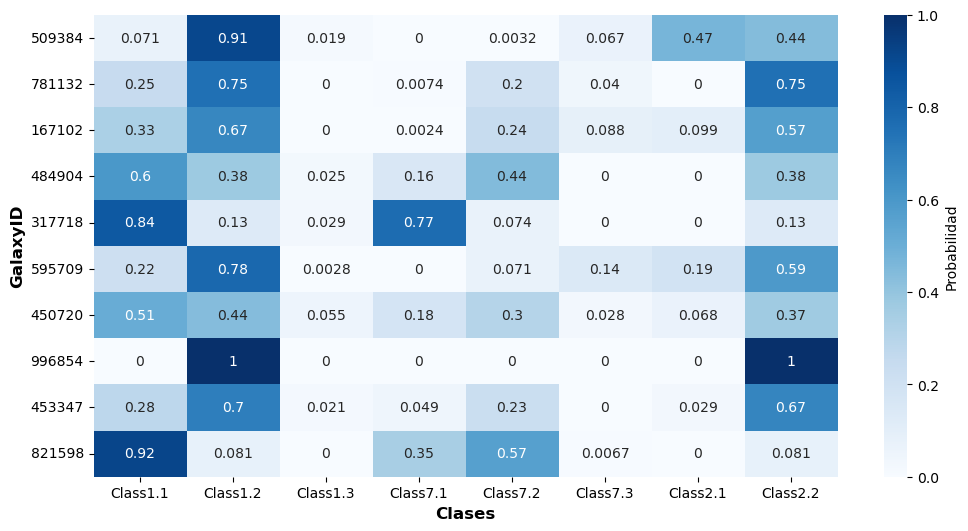

In [6]:
# Heatmap de probabilidades para las distintas clases
# 7.1 7.2 y 7.3 son subclases de 1.1, y suman su probabilidad
# 2.1 y 2.2 son subclases de 1.2, y suman su probabilidad

plt.figure(figsize=(12,6))
ax = sns.heatmap(df_train_sol.sample(frac=1).head(10).set_index('GalaxyID'), annot=True, cmap='Blues', cbar_kws={'label': 'Probabilidad'})
plt.xlabel('Clases',fontsize=12, fontweight='bold')
plt.ylabel('GalaxyID',fontsize=12, fontweight='bold')

In [7]:
# Comprobando que sume 1 cada muestra
df_train_sol[['Class1.1', 'Class1.2', 'Class1.3']].sum(axis=1).unique()

array([1.      , 1.      , 0.999999, 1.000001, 0.999999, 1.000001,
       0.999999, 1.      ])

In [8]:
# Verificando presencia de nulos o muestras duplicadas
nulos_totales = df_train_sol.isnull().sum().sum()
duplicados_totales = df_train_sol.duplicated().sum()
print('Valores nulos totales: {}'.format(nulos_totales))
print('Valores duplicados: {}'.format(duplicados_totales))

Valores nulos totales: 0
Valores duplicados: 0


In [9]:
# Como exploración básica, se muestran los estadisticos principales
df_train_sol.describe()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class7.1,Class7.2,Class7.3,Class2.1,Class2.2
count,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000
mean,550179.708337,0.432526,0.542261,0.025213,0.170021,0.207765,0.054740,0.106408,0.435854
std,258724.130197,0.283517,0.296429,0.037967,0.238860,0.215967,0.110445,0.212505,0.301867
min,100008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,327874.250000,0.175812,0.280862,0.000000,0.000000,0.032554,0.000000,0.000000,0.168490
50%,551933.000000,0.416994,0.558754,0.014870,0.035954,0.125757,0.000000,0.000000,0.394850
75%,773232.000000,0.679182,0.811339,0.034325,0.280679,0.333788,0.049136,0.085161,0.694615
max,999967.000000,1.000000,1.000000,0.935147,1.000000,1.000000,0.883481,1.000000,1.000000


# Etiquetas
Modificaciones de los dataframe para obtener etiquetas categoricas (en One-Hot Encoding)

In [10]:
df = df_train_sol.set_index('GalaxyID')
df.head()

,Class1.1,Class1.2,Class1.3,Class7.1,Class7.2,Class7.3,Class2.1,Class2.2
GalaxyID,,,,,,,,
100008,0.383147,0.616853,0.000000,0.201463,0.181684,0.000000,0.000000,0.616853
100023,0.327001,0.663777,0.009222,0.000000,0.135082,0.191919,0.031178,0.632599
100053,0.765717,0.177352,0.056931,0.000000,0.741864,0.023853,0.000000,0.177352
100078,0.693377,0.238564,0.068059,0.408599,0.284778,0.000000,0.000000,0.238564
100090,0.933839,0.000000,0.066161,0.494587,0.439252,0.000000,0.000000,0.000000


In [11]:
df1 = df[['Class1.1','Class1.2','Class1.3']]
df2 = df[['Class7.1','Class7.2','Class7.3']]
df3 = df[['Class2.1','Class2.2']]

In [12]:
def row_class3(df):
    for i in range(len(df)):
        idx = df.iloc[i].values.argmax()
        row = np.zeros(3)
        row[idx] = 1
        df.iloc[i] = row
    return df

def row_class2(df):
    for i in range(len(df)):
        idx = df.iloc[i].values.argmax()
        row = np.zeros(2)
        row[idx] = 1
        df.iloc[i] = row
    return df

## Primer nivel - Elipticas, espirales y artefactos

In [13]:
df1 = row_class3(df1)
df1.head()

/tmp/ipykernel_4804/3264313514.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[i] = row


,Class1.1,Class1.2,Class1.3
GalaxyID,,,
100008,0.0,1.0,0.0
100023,0.0,1.0,0.0
100053,1.0,0.0,0.0
100078,1.0,0.0,0.0
100090,1.0,0.0,0.0


## Segundo nivel - Que tan redondeada?

In [14]:
# Indices para imagenes que son elipticas
idx2 = df1[df1['Class1.1']==1.0].index
idx2

Index([100053, 100078, 100090, 100122, 100123, 100128, 100288, 100295, 100402,
       100428,
       ...
       999680, 999687, 999731, 999781, 999786, 999873, 999936, 999948, 999950,
       999967],
      dtype='int64', name='GalaxyID', length=26693)

In [15]:
# Modifica dataframe segun nuevos indices
df2 = df2.reindex(idx2)
df2

,Class7.1,Class7.2,Class7.3
GalaxyID,,,
100053,0.000000,0.741864,0.023853
100078,0.408599,0.284778,0.000000
100090,0.494587,0.439252,0.000000
100122,0.066807,0.663691,0.008335
100123,0.388158,0.074334,0.000000
...,...,...,...
999873,0.358217,0.173425,0.000000
999936,0.010209,0.345441,0.189793
999948,0.000000,0.410816,0.099563


In [16]:
# Dataframe resultante en One Hot encoding
df2 = row_class3(df2)
df2

,Class7.1,Class7.2,Class7.3
GalaxyID,,,
100053,0.0,1.0,0.0
100078,1.0,0.0,0.0
100090,1.0,0.0,0.0
100122,0.0,1.0,0.0
100123,1.0,0.0,0.0
...,...,...,...
999873,1.0,0.0,0.0
999936,0.0,1.0,0.0
999948,0.0,1.0,0.0


## Segundo nivel - Es vista desde el borde?

In [17]:
# Indices para espirales
idx3 = df1[df1['Class1.2']==1.0].index
idx3

Index([100008, 100023, 100134, 100143, 100150, 100157, 100187, 100204, 100237,
       100259,
       ...
       999689, 999753, 999777, 999795, 999875, 999890, 999893, 999900, 999958,
       999964],
      dtype='int64', name='GalaxyID', length=34826)

In [18]:
# Se aplican indices
df3 = df3.reindex(idx3)
df3

,Class2.1,Class2.2
GalaxyID,,
100008,0.000000,0.616853
100023,0.031178,0.632599
100134,0.021751,0.955201
100143,0.730157,0.000000
100150,0.000000,0.524901
...,...,...
999890,0.691971,0.000000
999893,0.051956,0.467604
999900,0.109439,0.401957


In [19]:
# Dataframe resultante en One Hot encoding
df3 = row_class2(df3)
df3.head()

,Class2.1,Class2.2
GalaxyID,,
100008,0.0,1.0
100023,0.0,1.0
100134,0.0,1.0
100143,1.0,0.0
100150,0.0,1.0


In [20]:
# Cuantas muestras hay por clase?
df1.sum()

Class1.1    26693.0
Class1.2    34826.0
Class1.3       59.0
dtype: float64

In [21]:
df2.sum().sort_values()

Class7.3     1586.0
Class7.1    12039.0
Class7.2    13068.0
dtype: float64

In [22]:
df3.sum().sort_values()

Class2.1     6680.0
Class2.2    28146.0
dtype: float64

## Conteo por clases

In [23]:
df_class = pd.concat([df1,df2,df3], axis=1)
df_class.sum()

Class1.1    26693.0
Class1.2    34826.0
Class1.3       59.0
Class7.1    12039.0
Class7.2    13068.0
Class7.3     1586.0
Class2.1     6680.0
Class2.2    28146.0
dtype: float64

/tmp/ipykernel_4804/945718236.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y1 = np.array([df2.sum().sort_values()[0], df3.sum().sort_values()[0]])
/tmp/ipykernel_4804/945718236.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = np.array([df2.sum().sort_values()[1], df3.sum().sort_values()[1]])
/tmp/ipykernel_4804/945718236.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y3 = np.array([df2.sum().sort_values()[2], np.

(0.0, 40000.0)

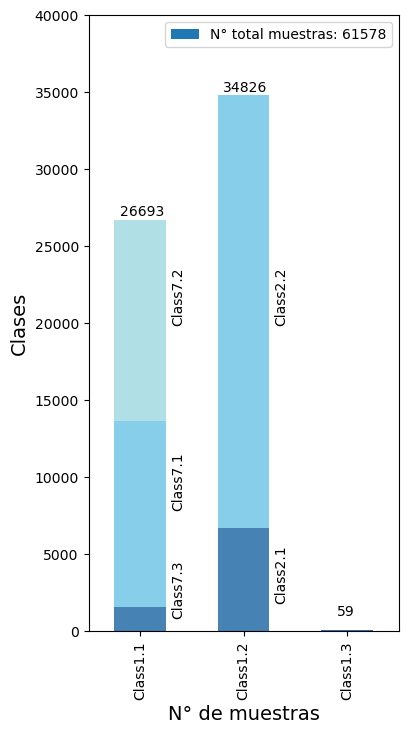

In [24]:
plt.figure(figsize=(4,8))
df_class.reset_index()[['Class1.1', 'Class1.2', 'Class1.3']].sum().plot(kind='bar')

x = ['Class1.1', 'Class1.2']
y1 = np.array([df2.sum().sort_values()[0], df3.sum().sort_values()[0]])
y2 = np.array([df2.sum().sort_values()[1], df3.sum().sort_values()[1]])
y3 = np.array([df2.sum().sort_values()[2], np.NaN])
plt.bar(x, y1, width=0.5, color='steelblue')
plt.bar(x, y2, bottom=y1, width=0.5, color='skyblue')
plt.bar(x, y3, bottom=y2+y1, width=0.5, color='powderblue')

plt.annotate('26693',(-0.2, 27000))
plt.annotate('34826',(0.80, 35000))
plt.annotate('59',(1.9, 1000))

plt.annotate('Class7.2',(0.3, 20000), rotation=90)
plt.annotate('Class7.1',(0.3, 8000), rotation=90)
plt.annotate('Class7.3',(0.3, 1000), rotation=90)

plt.annotate('Class2.2',(1.3, 20000), rotation=90)
plt.annotate('Class2.1',(1.3, 2000), rotation=90)

plt.legend(['N° total muestras: 61578'])
plt.ylabel('Clases', fontsize=14)
plt.xlabel('N° de muestras', fontsize=14)
plt.ylim([0, 40000])

## Gráficos para muestras aleatorias y comportamiento de clases

In [25]:
# Dataframe con probabilidades con clase
df_train_sol = df_train_sol[['GalaxyID','Class1.1','Class1.2','Class1.3']]

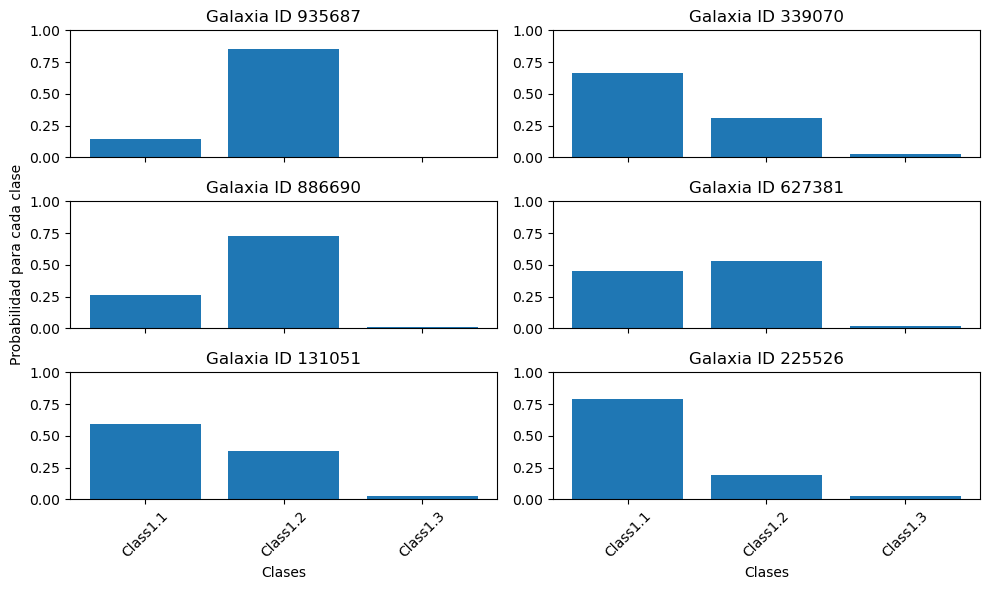

In [26]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharex=True)

x = np.arange(1,len(df_train_sol)) # indices posibles

for i in range(6):
    idx = random.choice(x) # Aleatoriza la muestra para mejor analisis
    etiquetas = df_train_sol.columns[1:]
    alturas = df_train_sol.iloc[idx, 1:].tolist()

    row, col = divmod(i, 2)
    ax = axes[row, col]

    ax.bar(etiquetas, alturas)
    if i==2:
         ax.set_ylabel('Probabilidad para cada clase')
    if i>=4:
        ax.set_xlabel('Clases')
        ax.tick_params(axis='x', rotation=45)
    
    ax.set_title('Galaxia ID {}'.format(df_train_sol['GalaxyID'][idx]))
    ax.set_ylim([0,1])

plt.tight_layout()
plt.show()

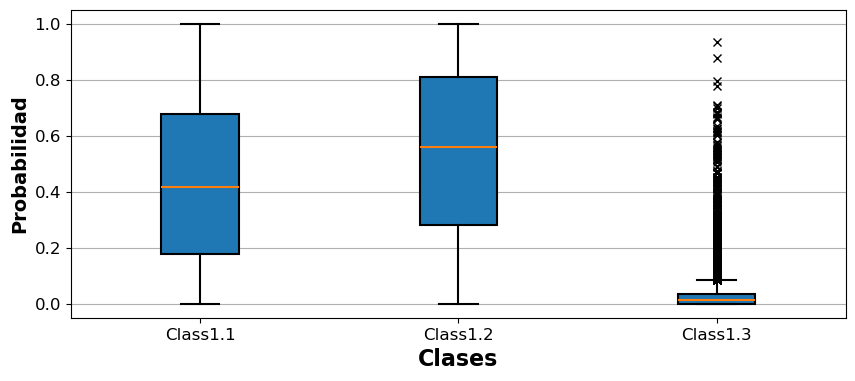

In [27]:
# Se muestra la probabilidad por clase de todas las muestras en forma de boxplot
fig, ax = plt.subplots(1,1,figsize=(10, 4))
df = df_train_sol[df_train_sol.columns[1:]]

box = df.plot(kind='box', ax=ax, fontsize=12, patch_artist=True,
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(marker='x'),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=True, rot=0)

ax.yaxis.grid(True)
ax.set_xlabel('Clases', fontsize=16, fontweight='bold')
ax.set_ylabel('Probabilidad', fontsize=14, fontweight='bold')
plt.show()

In [28]:
path_train = 'images_training_rev1/'
path_test = 'images_test_rev1/'

In [29]:
def plot_random_galaxy(path, sample = 4):
    random_image=random.sample(os.listdir(path),sample)
 
    plt.figure(figsize=(16,5))
    for i in range(sample):
        
        plt.subplot(1,sample,i+1)
        img=tf.io.read_file(os.path.join(path,random_image[i]))
        img=tf.io.decode_image(img)
        plt.imshow(img)
        plt.title(f'GalaxyID: {random_image[i][:-4]}', fontsize=14, fontweight='bold')
        plt.axis(False)

Se grafican muestras aleatorias para mostrar el tipo de datos que se manejará (imágenes)

2024-07-03 23:58:40.164003: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


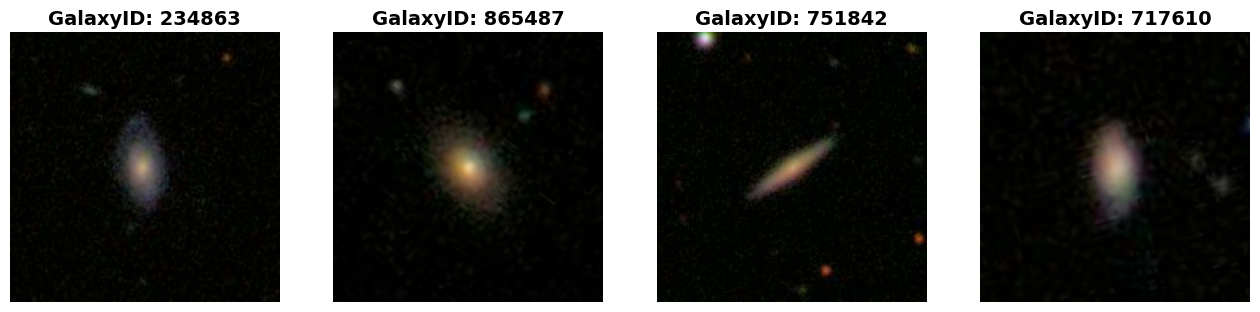

In [30]:
plot_random_galaxy(path_train)

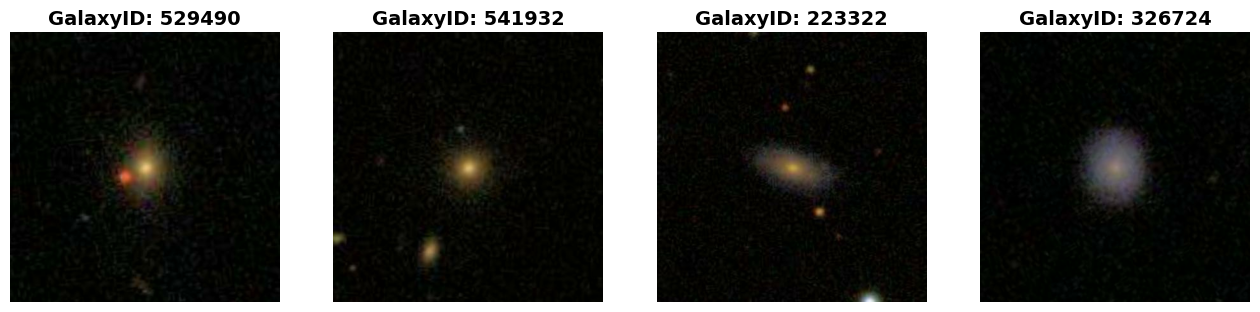

In [31]:
plot_random_galaxy(path_test)

# Preparaciones

In [32]:
# Lista de archivos de entrenamiento
files = os.listdir(path_train)
files.sort()

In [33]:
# Checking info of image, minmax and resolution
image = Image.open(path_train + files[0])

print("Infor. Imagen")
print(image.format)
print(image.size)
print(image.mode)

Infor. Imagen
JPEG
(424, 424)
RGB


In [34]:
# Transformaciones y augmentation
transform_image = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomRotation(360), # Not sure about this one
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.CenterCrop(224),
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

transform_valtest = transforms.Compose([transforms.ToTensor(),
                                       transforms.CenterCrop(224),
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [35]:
# Modelo
model = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14_reg") # 384 emb
#model = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14") # 768 emb
#model = torch.hub.load("facebookresearch/dinov2", "dinov2_vitl14") # 1024 emb
#model = torch.hub.load("facebookresearch/dinov2", "dinov2_vitg14") # 1536 emb

Using cache found in /home/yisus/.cache/torch/hub/facebookresearch_dinov2_main
/home/yisus/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/yisus/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/yisus/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [36]:
torch.cuda.is_available()

False

In [37]:
# Usar GPU si esta disponible
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Current device:',device)
model.to(device)

for id, module in enumerate(model.named_modules()):
    print(id,module)

Current device: cpu
0 ('', DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2)

## Etiquetas (binario)

In [38]:
df_class = df1

In [39]:
df_class.head()

,Class1.1,Class1.2,Class1.3
GalaxyID,,,
100008,0.0,1.0,0.0
100023,0.0,1.0,0.0
100053,1.0,0.0,0.0
100078,1.0,0.0,0.0
100090,1.0,0.0,0.0


In [40]:
# Si es necesario quitar la 3ra clase:
y = df_class[df_class['Class1.3']!=1.0]
y = y.drop(columns='Class1.3')
#y2['target'] = y2.target - 1
y.head()

# Con esto queda un problema binario de clasificacion con 0 = eliptico, 1 = espiral

,Class1.1,Class1.2
GalaxyID,,
100008,0.0,1.0
100023,0.0,1.0
100053,1.0,0.0
100078,1.0,0.0
100090,1.0,0.0


## Etiquetas multiclase (3 clases)

In [41]:
# Se considera elipticas y espirales vistas desde el lado u otro angulo
y.head() # Ya contiene el caso binario
y.shape

(61519, 2)

In [42]:
# Para hacer el caso 3 clases, es necesario reemplazar la columna 1.2 por el dataframe df3, que tiene el one-hot encoding de las espirales
df3.head()

,Class2.1,Class2.2
GalaxyID,,
100008,0.0,1.0
100023,0.0,1.0
100134,0.0,1.0
100143,1.0,0.0
100150,0.0,1.0


In [43]:
# Dropear y concatenar ambas
new_y = pd.concat([y.drop(columns=['Class1.2']), df3], axis=1)
new_y = new_y.fillna(.0)
new_y.head()

,Class1.1,Class2.1,Class2.2
GalaxyID,,,
100008,0.0,0.0,1.0
100023,0.0,0.0,1.0
100053,1.0,0.0,0.0
100078,1.0,0.0,0.0
100090,1.0,0.0,0.0


<Axes: >

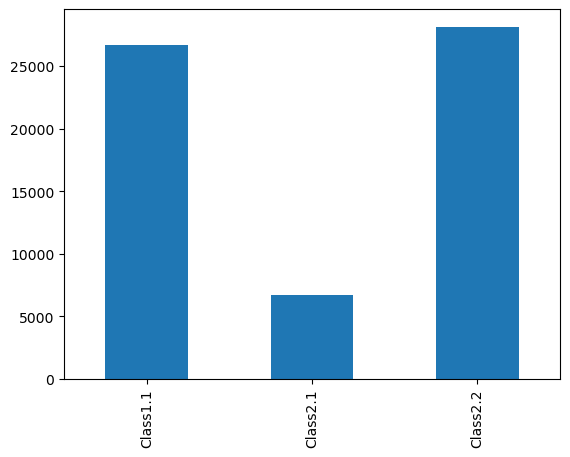

In [44]:
# Hay que darle una manito de gato a este grafico
new_y.sum().plot(kind='bar')

## GalaxyID a imagen

In [45]:
# Función para obtener imagen y etiqueta según GalaxyID
def ID2img(ID):
    #label = y.loc[ID].values
    
    img = path_train + str(ID)+'.jpg'
    img = Image.open(img)
    return img#, label

### Ejemplo 1 imagen

In [46]:
# Obtiene imagen y etiqueda para la primera GalaxyID
img = ID2img(y.index.values[1])

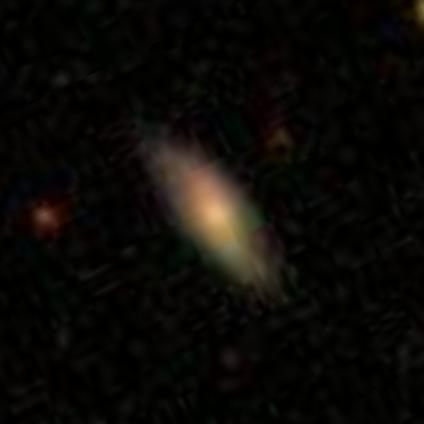

In [47]:
# Imagen
img

In [48]:
# Transformaciones
img = transform_image(img).unsqueeze(0)
print(img.size())

torch.Size([1, 3, 224, 224])


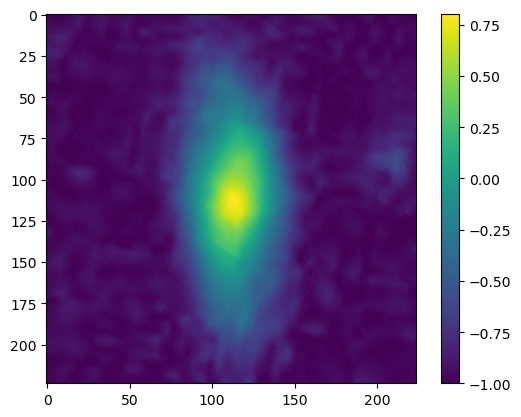

In [49]:
plt.imshow(img[0,0,:,:])
plt.colorbar()

In [50]:
# Obtener embedding (este proceso será interno en la arquitectura)
emb = model(img) # Quitar .cuda si no hay gpu

In [51]:
emb

tensor([[ 7.0166e-02, -1.1143e+00, -1.3279e+00,  6.8296e-01,  1.2470e+00,
          4.0719e-01, -1.5664e-01, -3.5617e-02,  2.8481e-01, -3.0496e-01,
         -1.0256e+00,  4.7007e-01,  1.1758e+00, -1.6853e+00, -1.8412e-01,
          2.6233e-03, -3.3225e-01,  7.6934e-01,  7.6367e-01,  1.1569e+00,
          6.4956e-01, -1.7105e-02,  1.1501e+00,  1.4391e-01,  2.1005e+00,
         -7.1526e-01, -2.2558e-01, -1.8996e+00,  9.1519e-02,  2.6046e+00,
         -1.3902e+00, -1.7042e+00,  1.8396e-01,  1.9561e+00,  2.9316e-01,
         -2.1769e-01, -7.3472e-01,  3.7033e-01, -4.0294e-02,  1.9633e+00,
         -2.4792e+00,  6.6772e-01,  1.2882e+00,  3.7119e-01, -4.9272e-01,
         -4.2620e-02, -9.6620e-01, -3.2145e-01, -1.3804e+00, -4.6242e-01,
          6.0297e-01, -2.2624e-01, -2.3949e-01,  4.4589e-01, -1.9830e-01,
         -7.5601e-01,  9.3721e-01,  6.1397e-02, -8.6029e-01,  1.8388e+00,
         -1.4819e+00,  1.1694e+00, -4.2452e-01, -1.4176e+00,  1.9650e+00,
         -1.3576e+00,  2.2660e+00,  2.

In [52]:
model_output = emb.squeeze().size(0)
print(model_output)

384


In [53]:
# Datos a utilizar para entrenamiento, considerar que se usará ID2img y transforms especificados más arriba
X = y.index.values
y = y.to_numpy()

In [54]:
X

array([100008, 100023, 100053, ..., 999958, 999964, 999967])

In [55]:
y

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

# Dataset y Dataloader

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, new_y.to_numpy(), test_size=0.33)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [57]:
print("Size train:", X_train.shape)
print("Size val:", X_val.shape)
print("Size test:", X_test.shape)

Size train: (30912,)
Size val: (10305,)
Size test: (20302,)


In [58]:
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [59]:
class CDataset(torch.utils.data.Dataset):
    # CustomDataset modificado de código de prácticas.
    def __init__(self, galaxyid, labels, tfr, tfr_model):
        self.data = galaxyid # X
        self.labels = labels # y
        self.transform = tfr
        self.transform_model = tfr_model

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        ID = self.data[idx]
        img = ID2img(ID) # unsqueeze(0)
        
        if self.transform:
            img = self.transform(img)
            # img = self.transform_model(img.to(device).unsqueeze(0)).squeeze(0) # quitar .cuda() si no usa gpu
            
        return img.cpu(), self.labels[idx] # Se transforma a cpu para que la capa FF se trabaje en cpu

In [60]:
class CDataloader(torch.utils.data.DataLoader):
    def __init__(self, Xtrain, ytrain, Xval, yval, Xtest, ytest,
                    tfr_train  = None,
                    tfr_val    = None,
                    tfr_test   = None,
                    tfr_model  = None,
                    batch_size = 64,
                    shuffle    = False):

        # Atributes and labels
        self.xtrain, self.ytrain = Xtrain, ytrain
        self.xval, self.yval     = Xval, yval
        self.xtest, self.ytest   = Xtest, ytest

        # Number of categories
        self.nb_labels = self.ytrain.size(1)

        # Transformations
        self.tfr_train = tfr_train
        self.tfr_val   = tfr_val
        self.tfr_test  = tfr_test
        
        self.tfr_model = tfr_model

        # Loader
        self.__loader(batch_size, shuffle)

    def __loader(self, batch_size, shuffle):
        
        # Create the Datasets
        train_set = CDataset(galaxyid = self.xtrain, labels = self.ytrain, tfr=self.tfr_train, tfr_model = self.tfr_model)
        val_set   = CDataset(galaxyid = self.xval  , labels = self.yval  , tfr=self.tfr_val,   tfr_model = self.tfr_model)
        test_set  = CDataset(galaxyid = self.xtest , labels = self.ytest , tfr=self.tfr_test,  tfr_model = self.tfr_model)

        # Create the Dataloaders
        self.train_set = torch.utils.data.DataLoader(dataset   = train_set,
                                                    batch_size = batch_size,
                                                    shuffle    = shuffle)

        self.val_set   = torch.utils.data.DataLoader(dataset   = val_set,
                                                    batch_size = batch_size,
                                                    shuffle    = False)
        
        self.test_set  = torch.utils.data.DataLoader(dataset   = test_set,
                                                    batch_size = batch_size,
                                                    shuffle    = False)

In [61]:
# Ejecucion datos
loader = CDataloader(Xtrain = X_train, ytrain = y_train, Xval = X_val, yval = y_val, Xtest = X_test, ytest = y_test,
                                tfr_train  = transform_image,
                                tfr_val    = transform_valtest,
                                tfr_test   = transform_valtest,
                                tfr_model  = None,
                                batch_size = 64, # Con este valor la gpu ocupa ~3 gb de vram
                                shuffle    = True)

print(f"CDataloader fue ejecutado correctamente")
print(110*"_")

# Checking input size and number of classes ---------------------------------------------------------#
input_size  = loader.train_set.dataset.data.shape 
num_classes = loader.nb_labels

print(f"Input del dataset:        {input_size}")
print(f"Cantidad de categorias:   {num_classes}")

CDataloader fue ejecutado correctamente
______________________________________________________________________________________________________________
Input del dataset:        (30912,)
Cantidad de categorias:   3


In [62]:
## Para desactivar la gradiente en ciertas capas de dino
def disable_gradients(module):
    for param in module.parameters():
        param.requires_grad = False

    for child in module.children():
        disable_gradients(child)

In [63]:
# Testing functionality of loader
#train_features, train_labels = next(iter(loader.test_set))

#print("Loader train_data batch size :", train_features.size())
#print("Loader train_label batch size:", train_labels.size())

In [64]:
# Revisemos embeddings desde Dataloader
#img = train_features[0].squeeze()
#label = train_labels[0]
#plt.imshow(img[0,:,:])
#plt.colorbar()
#plt.show()
#print(f"Label: {label}")

# Trainer

In [65]:
class EarlyStopping:
    # EarlyStopping basado en la métrica (Accuracy)
    def __init__(self, patience=5, delta=0.001, verbose=False):
        # Inicializar parámetros
        self.best_metric = -np.Inf 
        self.counter = 0
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
    
    # Contador para EarlyStopping
    def count(self, metric):
        # Si métrica es mejor que la anterior + delta, is_best = True
        is_best = bool(metric > (self.best_metric+self.delta))

        # Actualizamos el valor del contador
        if is_best: # Si is_best = True, reiniciar contador
            print(f'Incremento en Accuracy: [{self.best_metric:.6f} > {metric:.6f}]. Creando checkpoint.')
            self.counter = 0
        else: # Caso contrario, incrementar contador para EarlyStopping
            print(f'Sin mejora en Accuracy: [{self.counter}/{self.patience}]')
            self.counter += 1

        # Actualizamos métrica si es mayor a la ya definida
        self.best_metric = max(metric, self.best_metric)

        # Analizamos si es necesario o no detener el entrenamiento
        stop = bool(self.counter > self.patience)

        return stop, is_best

In [66]:
class CTrainer(object):
    def __init__(self, arch, hyper, model_instance, verbose=True):
        super(CTrainer, self).__init__()
        self.architecture   = arch                                                # Parametros de la red
        self.hyperparams    = hyper                                               # Hiperparametros del modelo
        self.model_class    = model_instance                                      # Modelo que usaremos
        self.verbose        = verbose                                             # Si desamos o no los prints

    def compile(self, load_checkpoint):
        self.model      = self.model_class(self.architecture)
        self.loss       = torch.nn.CrossEntropyLoss() # Por el momento que es binario
        self.optimizer  = torch.optim.Adam(params=self.model.parameters(), lr = self.hyperparams["lr"])
        self.early_stop = EarlyStopping(patience=self.hyperparams["patience"], delta=0.001)

        self.history   = {  "epochs"    : [],
                            "train_loss": [], "train_metric":[],
                            "val_loss"  : [], "val_metric"  :[]}

        if load_checkpoint:
            state_dict = torch.load('{}/trained_parameters.pth'.format(self.hyperparams["exp"]))

            self.model.load_state_dict(state_dict['model'])
            self.optimizer.load_state_dict(state_dict['optim'])

            print('Training parameters restored.')
            
    def fit(self, train_dl, val_dl):
        for epoch in range(0, self.hyperparams["nepochs"]+1):
            train_loss, train_metric = self.__train_one_epoch(train_dl)
            val_loss  , val_metric   = self.__val_one_epoch(val_dl)

            epoch_train_loss     = np.mean(train_loss)
            epoch_train_metric   = np.mean(train_metric)

            epoch_val_loss       = np.mean(val_loss)
            epoch_val_metric     = np.mean(val_metric)

            if self.verbose:
                print(f'\nEpoch: {epoch}/{self.hyperparams["nepochs"]} '
                        + f'loss = {epoch_train_loss:.4f}, '
                        + f'metric = {epoch_train_metric:.4f}, ')

            self.history["epochs"].append(epoch)
            self.history["train_loss"].append(epoch_train_loss)
            self.history["train_metric"].append(epoch_train_metric)
            self.history["val_loss"].append(epoch_val_loss)
            self.history["val_metric"].append(epoch_val_metric)

            stop, is_best = self.early_stop.count(epoch_val_metric)

            if is_best:
                cpkt = {'model': self.model.state_dict(),
                        'optim': self.optimizer.state_dict()}
                torch.save(cpkt, './{}/trained_parameters.pth'.format(self.hyperparams["exp"]))
                print("")
            if stop:
                break

    def summary(self):
        print(110*"_")
        print(self.model)
        for layer, param in self.model.named_parameters():
            print(100*"-")
            print(f'layer.param_type:    {layer}')
            print(f"n-params        :    {param.numel()}")
            print(100*"-")
        print(110*"_")

    def __train_one_epoch(self, dataloader):
        self.model.train()
        for i in range(11):
            disable_gradients(self.model.ViT.blocks[i])     # desactiva grad para todos los bloques excepto el ultimo (11)

        train_loss   = []
        train_metric = []

        for X_train, y_train in tqdm(dataloader, miniters=1):
            y_pred       = self.model(X_train.float())

            score_loss   = self.loss(y_pred, y_train.float())

            y            = torch.argmax(y_train, dim=-1).detach().numpy()
            y_hat        = torch.argmax(y_pred , dim=-1).detach().numpy()
            score_metric = accuracy_score(y, y_hat)

            # back, step, zero
            score_loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad(set_to_none=True)

            train_loss.append(score_loss.item())
            train_metric.append(score_metric)
        return train_loss, train_metric

    def __val_one_epoch(self, dataloader):
        self.model.eval()

        val_loss   = []
        val_metric = []

        with torch.no_grad():
            for X_val, y_val in tqdm(dataloader, miniters=1):
                y_preds_val  = self.model(X_val.float())

                score_loss   = self.loss(y_preds_val, y_val.float())

                y            = torch.argmax(y_val, dim=-1).detach().numpy()
                y_hat        = torch.argmax(y_preds_val , dim=-1).detach().numpy()
                score_metric = accuracy_score(y, y_hat)

                val_loss.append(score_loss.item())
                val_metric.append(score_metric)
        return val_loss, val_metric

    def evaluate(self, dataloader):
        self.model.eval()

        loss_list   = []
        metric_list = []

        with torch.no_grad():
            for X_test, y_test in tqdm(dataloader, miniters=1):
                y_preds_test = self.model(X_test.float())

                score_loss   = self.loss(y_preds_test, y_test.float())

                y            = torch.argmax(y_test, dim=-1).detach().numpy()
                y_hat        = torch.argmax(y_preds_test , dim=-1).detach().numpy()
                score_metric = accuracy_score(y, y_hat)

                loss_list.append(score_loss.item())
                metric_list.append(score_metric)

                loss_out = np.mean(loss_list)
                metric   = np.mean(metric_list)
        return loss_out, metric

    def predict(self, X):
        self.model.eval()

        y_pred_prob = []
        y_pred      = []

        with torch.no_grad():
            X      = X
            out    = self.model(X)

            #y_hat_prob = torch.nn.functional.softmax(out, dim=1)
            y_hat      = torch.argmax(out)
        return out, y_hat

# Arquitectura

In [67]:
class DinoV2Classifier(nn.Module):
    def __init__(self, Args_dict):
        super(DinoV2Classifier, self).__init__()
        emb_size = Args_dict["emb_size"]
        out_size = Args_dict["out_size"]
        
        self.ViT = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14_reg")
        self.act1 = nn.ReLU()
        self.act2 = nn.Sigmoid()
        
        self.fc1 = nn.Linear(emb_size, 256)
        self.fc2 = nn.Linear(256, out_size) # 64
        #self.fc3 = nn.Linear(64, out_size)
    
    def forward(self, x):
        x = self.ViT(x) 
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x)) #act1
        #x = self.act2(self.fc3(x))
        return x

# Compilación

In [68]:
architecture = {"emb_size": model_output, "out_size": num_classes}
hyperparams  = {"nepochs": 30, "lr":0.0005, "patience": 3, "exp": "./Model/"}

In [69]:
DINO = CTrainer(arch = architecture, hyper = hyperparams, model_instance = DinoV2Classifier)
DINO.compile(load_checkpoint=True)
DINO.summary()

Using cache found in /home/yisus/.cache/torch/hub/facebookresearch_dinov2_main


Training parameters restored.
______________________________________________________________________________________________________________
DinoV2Classifier(
  (ViT): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approxim

In [70]:
print("Entrenamiento DINOv2 Classifier")
print(110*"-")
DINO.fit(train_dl = loader.train_set, val_dl = loader.val_set)

Entrenamiento DINOv2 Classifier
--------------------------------------------------------------------------------------------------------------


100%|██████████| 162/162 [07:36<00:00,  2.82s/it]



Epoch: 0/30 loss = 0.8159, metric = 0.7095, 
Incremento en Accuracy: [-inf > 0.732928]. Creando checkpoint.



100%|██████████| 162/162 [07:32<00:00,  2.80s/it]



Epoch: 1/30 loss = 0.7997, metric = 0.7275, 
Incremento en Accuracy: [0.732928 > 0.742284]. Creando checkpoint.



100%|██████████| 162/162 [07:35<00:00,  2.81s/it]



Epoch: 2/30 loss = 0.7986, metric = 0.7311, 
Sin mejora en Accuracy: [0/3]


100%|██████████| 162/162 [07:30<00:00,  2.78s/it]



Epoch: 3/30 loss = 0.7877, metric = 0.7402, 
Incremento en Accuracy: [0.742284 > 0.748650]. Creando checkpoint.



100%|██████████| 162/162 [07:33<00:00,  2.80s/it]



Epoch: 4/30 loss = 0.7881, metric = 0.7397, 
Sin mejora en Accuracy: [0/3]


100%|██████████| 162/162 [07:32<00:00,  2.79s/it]



Epoch: 5/30 loss = 0.7902, metric = 0.7340, 
Sin mejora en Accuracy: [1/3]


100%|██████████| 162/162 [07:38<00:00,  2.83s/it]



Epoch: 6/30 loss = 0.7911, metric = 0.7346, 
Incremento en Accuracy: [0.748650 > 0.754533]. Creando checkpoint.



100%|██████████| 162/162 [07:38<00:00,  2.83s/it]



Epoch: 7/30 loss = 0.7900, metric = 0.7371, 
Sin mejora en Accuracy: [0/3]


100%|██████████| 162/162 [07:36<00:00,  2.81s/it]



Epoch: 8/30 loss = 0.7909, metric = 0.7356, 
Sin mejora en Accuracy: [1/3]


100%|██████████| 162/162 [07:32<00:00,  2.80s/it]



Epoch: 9/30 loss = 0.7893, metric = 0.7389, 
Incremento en Accuracy: [0.754533 > 0.757330]. Creando checkpoint.



100%|██████████| 162/162 [07:25<00:00,  2.75s/it]



Epoch: 10/30 loss = 0.8007, metric = 0.7239, 
Sin mejora en Accuracy: [0/3]


100%|██████████| 162/162 [07:29<00:00,  2.77s/it]



Epoch: 11/30 loss = 0.7998, metric = 0.7259, 
Sin mejora en Accuracy: [1/3]


100%|██████████| 162/162 [07:31<00:00,  2.78s/it]



Epoch: 12/30 loss = 0.7977, metric = 0.7255, 
Sin mejora en Accuracy: [2/3]


100%|██████████| 162/162 [07:30<00:00,  2.78s/it]


Epoch: 13/30 loss = 0.7874, metric = 0.7383, 
Sin mejora en Accuracy: [3/3]


# Performance

## Guardar resultados

In [71]:
# Curva de aprendizaje
# Extraer información necesaria del entrenamiento
epochs = DINO.history["epochs"]
loss = DINO.history["train_loss"]
loss_val = DINO.history["val_loss"]
metric = DINO.history["train_metric"]
metric_val = DINO.history["val_metric"]

In [72]:
# Guardar resultados modelo
results = np.array([epochs, loss, loss_val, metric, metric_val])
results = results.T

np.savetxt("Model/dino_results_3class.txt", results)

## Cargar resultados

In [ ]:
# Testing
#DINO = CTrainer(arch = architecture, hyper = hyperparams, model_instance = DinoV2Classifier)
#DINO.compile(load_checkpoint=True)

Training parameters restored.


In [ ]:
# Cargar datos
#results = np.loadtxt("dino_results.txt")
#results = results.T
#epochs = results[0]
#loss = results[1]
#loss_val = results[2]
#metric = results[3]
#metric_val = results[4]

## Resultados

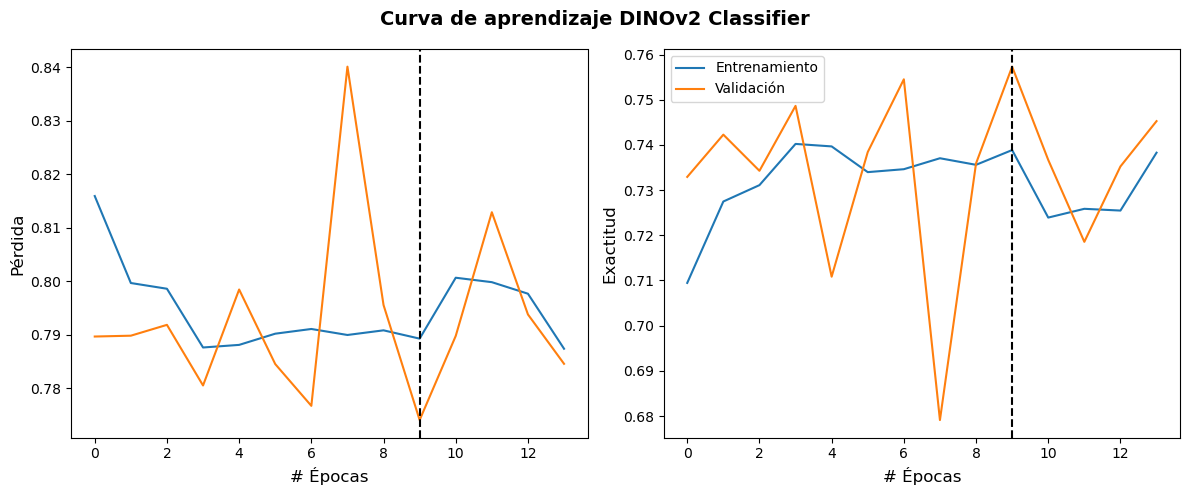

<Figure size 640x480 with 0 Axes>

In [73]:
# Configuración de las subfiguras
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Trazar la primera curva para Loss
axs[0].plot(epochs, loss)
axs[0].plot(epochs, loss_val)

best_pos = max(epochs)-hyperparams["patience"] # Mejor modelo
axs[0].axvline(best_pos-1, color='k', linestyle='--')
axs[0].set_ylabel('Pérdida', size=12)
axs[0].set_xlabel('# Épocas', size=12)

# Trazar la segunda curva para Accuracy
axs[1].plot(epochs, metric, label="Entrenamiento")
axs[1].plot(epochs, metric_val, label="Validación")
axs[1].axvline(best_pos-1, color='k', linestyle='--')
axs[1].set_ylabel('Exactitud', size=12)
axs[1].set_xlabel('# Épocas', size=12)

# Titulo
plt.suptitle('Curva de aprendizaje DINOv2 Classifier', size=14, weight='bold')

plt.legend()
plt.tight_layout()
plt.show()

plt.savefig("Model/learning_curve.png")

In [74]:
# Test
loss_test, metric_test = DINO.evaluate(loader.test_set)

100%|██████████| 318/318 [15:46<00:00,  2.98s/it]


In [75]:
print(loss_test, metric_test)

0.7804056595331468 0.7486312331536388


In [83]:
X_tfr = transform_valtest(ID2img(X_test[0]))
# X_tfr = model(X_tfr.cuda().unsqueeze(0)).squeeze(0)
yhat_prob, yhat = DINO.predict(transform_valtest(ID2img(X_test[0]).unsqueeze(0).squeeze(0)))

AttributeError: 'JpegImageFile' object has no attribute 'unsqueeze'

In [ ]:
# Obtenemos clase real y clase predicha para métricas
y_prob = []
y_pred = []
y_true = []

for i in tqdm(range(len(y_test)), miniters = 1):
    X_tfr = transform_valtest(ID2img(X_test[i]))
    X_tfr = model(X_tfr.cuda().unsqueeze(0)).squeeze(0)
    yhat_prob, yhat = DINO.predict(X_tfr.cpu())
    
    yhat = yhat.numpy()
    yhat_prob = yhat_prob.numpy()[yhat]
    
    y_true.append(torch.argmax(y_test[i]).numpy())
    y_pred.append(yhat)
    y_prob.append(yhat_prob)

  0%|          | 0/20302 [00:00<?, ?it/s]

In [ ]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

In [ ]:
# Cálculo de métricas
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("Precision: ", precision_score(y_true, y_pred))
print("Recall: ", recall_score(y_true, y_pred))
print("F1 Score: ", f1_score(y_true, y_pred))

Accuracy:  0.8319869963550389
Precision:  0.8410735318862528
Recall:  0.86787047486761
F1 Score:  0.8542619098483231


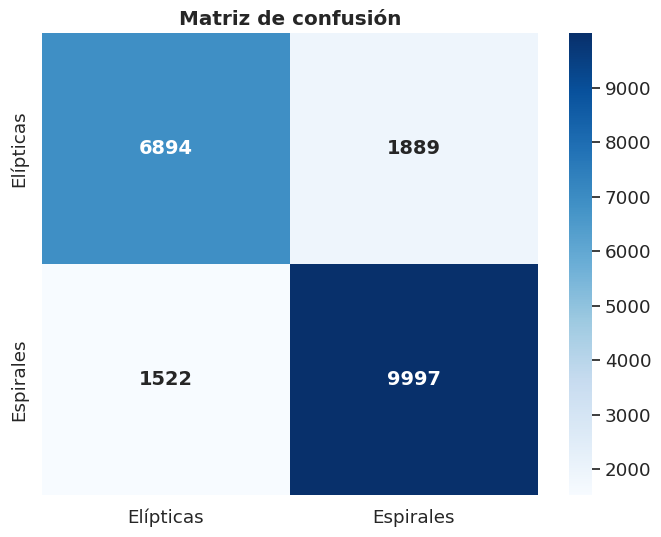

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='4.0f', xticklabels=['Elípticas', 'Espirales'], yticklabels=['Elípticas', 'Espirales'], 
            annot_kws={'fontsize':14,'fontweight':'bold'}, cmap='Blues')
plt.title('Matriz de confusión', weight='bold')

plt.savefig("Model/confusion_matrix.png")

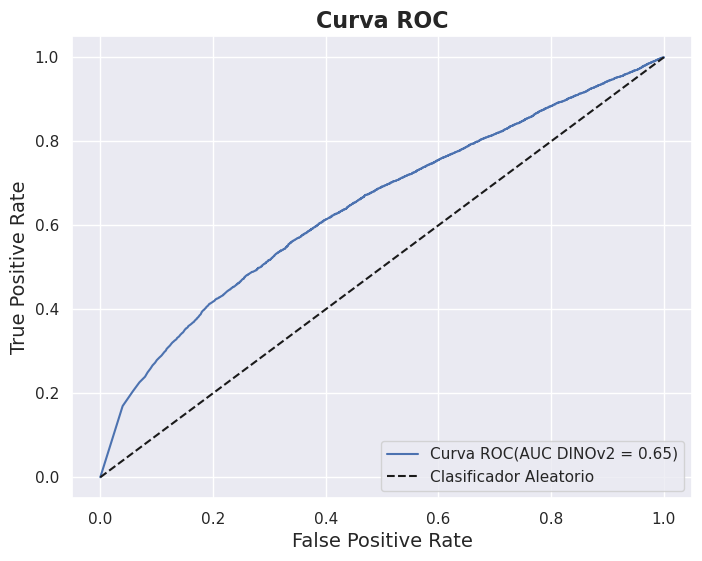

In [ ]:
# Curva ROC
fpr, tpr, thr = roc_curve(y_true, y_prob, pos_label=1) # Obtener métricas y threshold
roc_auc = roc_auc_score(y_true, y_prob) # Area bajo la curva de ROC (mayor = mejor)

# Plot curva ROC
sns.set(font_scale=1)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Curva ROC(AUC DINOv2 = %0.2f)' % roc_auc) 

plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio') 
plt.xlabel('False Positive Rate', size=14) 
plt.ylabel('True Positive Rate', size=14) 
plt.title('Curva ROC', size=16, weight='bold') 
plt.legend(loc="lower right") 
plt.show()